# PyTorch basics

<a href="https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/02-pytorch/homework.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

В этой тетрадке мы познакомимся с общими принципами построения нейронных сетей.

**Цели тетрадки**

1. Знакомство с базовыми слоями PyTorch
1. Практика в построении и обучении сетей

**(повтор) Материалы по pytorch:**

* [PyTorch docs](https://pytorch.org/docs/stable/index.html)
* [Классная статья про pytorch internal](http://blog.ezyang.com/2019/05/pytorch-internals/)

## Prerequirements

```
pip install torch torchvision numpy matplotlib
```

In [1]:
# https://stackoverflow.com/a/60658965/7286121

from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

## Hello MNIST

Прежде чем собирать сеть, давайте определим инстансы класса `Dataset`, которые будут возвращать примеры из тренировочной и валидационной выборок.  
С помощью ячейки ниже, мы скачаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/) в текущую директорию и сможем получать примеры из соответствующих объектов.

In [3]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

mnist_train = MNIST(root='./', train=True, download=True, transform=transform_to_tensor)
mnist_val = MNIST(root='./', train=False, download=True, transform=transform_to_tensor)

Посмотрим на несколько примеров из тренировочной выборки

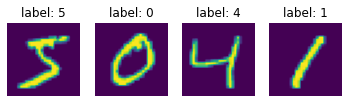

In [4]:
def show_examples(dataset: Dataset, num_examples: int = 4):
    fig, ax = plt.subplots(1, num_examples)
    
    for i in range(num_examples):
        img, label = dataset[i]
        ax[i].imshow(img[0])
        ax[i].set_title(f'label: {label}')
        ax[i].axis('off')
    plt.show()
    
    
show_examples(dataset=mnist_train)

## Задание 1
**(0.5 балла)** Напишите свою версию датасета, который будет читать картинки с диска.  
Подразумевается, что если вы написали свой датасет, то он будет использоваться при обучении вместо дефолтного `MNIST`.  

В ячейках ниже сгенерится датасет в таком формате:
- /MNIST_image_folder
    - /train.csv
    - /train/{class_name}/{image_name}.png
    - /val.csv
    - /val/{class_name}/{image_name}.png

CSV файлы содержат название файла и его лейбл: `image`, `label`.

*Hint 1:* нужно унаследоваться от класса `Dataset` и переопределить методы `__getitem__` и `__len__`.
Первый должен возвращать картинку и ее лейбл, а второй количество примеров в датасете.
(На самом деле второй метод не обязателен для самого датасета, но он необходим для
[семплера](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler),
который используется даталоадером)
(см. [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
[PyTorch tutorual](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset))  
*Hint 2:* для работы с картинками лучше использовать OpenCV: `pip install opencv-python-headless`.
В частности [cv2.imread](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56).  
*Hint 3:* обратите особое внимание на то, что возвращает функция `cv2.imread` (пример загрузки изображения с помощью cv2 есть в семе)


In [5]:
import pickle
import numpy as np
import os
import cv2
from collections import Counter
from tqdm.auto import tqdm
import pandas as pd

def generate_image_folder_dataset(dataset, target_path, csv_path):

    images_counter = Counter()

    files = []
    labels = []

    for image, label in tqdm(dataset):
        class_folder = target_path + "/" + str(label)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder, exist_ok=True)

        images_counter[label] += 1
        file_name = f"/{images_counter[label]:05}.png"
        full_image_file_name = class_folder + file_name

        files.append(str(label) + file_name)
        labels.append(label)

        image = np.array(image)
        image = (image * 255).astype(np.uint8)
        image = np.transpose(image, [1, 2, 0])
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # print(image.dtype)
        # print(image.shape)
        cv2.imwrite(full_image_file_name, image)

        # break
    pd.DataFrame({ "image": files, "label": labels }).to_csv(csv_path, index=False)

generate_image_folder_dataset( mnist_train,  "./MNIST_image_folder/train", "MNIST_image_folder/train.csv" )
generate_image_folder_dataset( mnist_val,  "./MNIST_image_folder/val", "MNIST_image_folder/val.csv" )

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Теперь можно написать свой класс датасета для тех файлов, которые мы сгенерили

In [6]:
%%write_and_run dataset_mnist.py 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2

class DatasetMNIST(Dataset):
    def __init__(self, root='./MNIST_image_folder', train=True, transform=None):
        self.transform = transform
        if train:
            self.root = root + '/train'
        else:
            self.root = root + '/val'
        with open(self.root + '.csv', mode='r') as f:
            self.data = f.readlines()[1:]
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        line = self.data[index][:-1].split(',')
        img = cv2.imread(self.root+'/'+line[0], cv2.IMREAD_GRAYSCALE)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).type(torch.float32).unsqueeze(0)
        label = int(line[1])

        return dict(image=img, label=label)

тест класса датасета

In [7]:
def test_dataset(dataset, test_name=""):

    assert len(dataset) > 0, f"{test_name}: dataset length is greater then zero"

    idateset = iter(dataset)
    item = next(idateset)

    assert isinstance(item, dict), f"{test_name}: dataset returned dict"
    assert "image" in item, f"{test_name}: dataset item dict has image"
    assert "label" in item, f"{test_name}: dataset item dict has label"

    assert item['image'].shape == (1, 28, 28), f"{test_name}: dataset image shape is correct. Got: {item['image'].shape}"

mydataset = DatasetMNIST(train=False, transform=transform_to_tensor)
test_dataset(mydataset, test_name="val")

mydataset = DatasetMNIST(train=True, transform=transform_to_tensor)
test_dataset(mydataset, test_name="train")

## Задание 2
**(0.3 балла)** Напишите класс MLP сети из 3 линейных слоев, которая будет получать на вход
батч картинок размера [BS, C, H, W]

*Hint 1:* метод `.flatten(start_dim=1)` поможет вытянуть картинку в вектор.  
*Hint 2:* выход должен соответствовать количеству лейблов, то есть 10.  
*Hint 3:* пачка линейных слоев подряд не имеет смысла без нелинейностей между ними. Попробуйте разные слои нелинейности (один слой на один эксперимент): `ReLU`, `LeakyReLU`, `Tanh` ... [Другие](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

In [8]:
%%write_and_run custom_mlp.py 

# важно! все зависимости, которые используете (если добавляее новые) в этом классе надо явно продублировать в эту ячейку
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomMLP(nn.Module):
    def __init__(self,
                 num_pixels_per_img: int = 784,  # hint: 28*28 == 784
                 ):
        super().__init__()
        self.inner = nn.Sequential(
            nn.Linear(num_pixels_per_img, 1500),
#             nn.ReLU(),
#             nn.LeakyReLU(),
            nn.Tanh(),
            nn.Linear(1500, 200),
#             nn.ReLU(),
#             nn.LeakyReLU(),
            nn.Tanh(),
            nn.Linear(200, 10),
#             nn.ReLU(),
#             nn.LeakyReLU(),
            nn.Tanh()
        )

    def forward(self, x):
        return self.inner(x.flatten(start_dim=1))

    def compute_all(self, batch):
        x = batch['image']
        y = batch['label']
        logits = self.inner(x.flatten(start_dim=1))
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 3
**(0.3 балла)** Напишите класс CNN сети из 3 сверточных слоев.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* описание сверточных слоев [PyTorch docs](https://pytorch.org/docs/stable/nn.html#convolution-layers). Нам нужен `Conv2d`

Тут тоже можете поэксперементировать с разными слоями активации.

Чтобы было проще считать размерности для конечного слоя, используйте `kernel_size=3, padding=1` в сверточных слоях

In [9]:
%%write_and_run custom_cnn.py 

# важно! все зависимости, которые используете (если добавляее новые) в этом классе надо явно продублировать в эту ячейку
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.inner = nn.Sequential(
            # [ bs, ch, w, h ]
            nn.Conv2d(1, 12, kernel_size=3, padding=1),
#             nn.ReLU(),
            nn.LeakyReLU(),
#             nn.Tanh(),
            nn.Conv2d(12, 8, kernel_size=3, padding=1),
#             nn.ReLU(),
            nn.LeakyReLU(),
#             nn.Tanh(),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
#             nn.ReLU(),
            nn.LeakyReLU(),
#             nn.Tanh()
            nn.Flatten(1), # [ bs, 3 * w * h ]
            nn.Linear(4 * 28 * 28, 10)
        )

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']
        logits = self.inner(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 4
**(0.3 балла)** Напишите класс CNN сети из 3 блоков с добавлением skip-connection блока
(ResNet [paper](https://arxiv.org/abs/1512.03385)).  
**(0.3 балла)** Реализовать residual блок в отдельном классе `ResBlock`.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* пример skip-connection:  
![image](https://i1.wp.com/dangminhthang.com/wp-content/uploads/2020/06/resnet-block.jpg?fit=400%2C225)

In [10]:
%%write_and_run custom_resnet.py 

# важно! все зависимости, которые используете (если добавляее новые) в этом классе надо явно продублировать в эту ячейку
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        """
        in_dim --- размерность слоев на входе (используется в nn.Conv2d)
        hidden_dim --- скрытая размерность слоев (используется в nn.Conv2d)
        """
        self.inner = nn.Sequential(
            nn.Conv2d(in_dim, hidden_dim, kernel_size=3, padding=1),
#             nn.ReLU(),
            nn.LeakyReLU(),
#             nn.Tanh(),
            nn.Conv2d(hidden_dim, in_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.inner(x) + x


class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inner = nn.Sequential(
            # [ bs, ch, w, h ]
            nn.Conv2d(1, 12, kernel_size=3, padding=1),
#             nn.ReLU(),
            nn.LeakyReLU(),
#             nn.Tanh(),
            nn.Conv2d(12, 8, kernel_size=3, padding=1),
#             nn.ReLU(),
            nn.LeakyReLU(),
#             nn.Tanh(),
            ResBlock(8, 16),
#             nn.ReLU(),
            nn.LeakyReLU(),
#             nn.Tanh(),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
#             nn.ReLU(),
            nn.LeakyReLU(),
#             nn.Tanh()
            nn.Flatten(1), # [ bs, 3 * w * h ]
            nn.Linear(4 * 28 * 28, 10)
        )

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']
        logits = self.inner(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 5
**(0.3 балла)** Инициализируйте и обучите сети из пунктов 1, 2, 3, используя класс `Trainer` из семинара.

В тренерене, возможно, вы захотите писать больше метрик: лосс во время трейна, валидационный лосс, валидационные метрики (можно префиксовать валидационные метрики с помощью "val", чтобы не путались)

Каждая модель должна побить определенные пороги кач-ва (> 0.8 за 3 эпохи)

In [11]:
from torch.utils.tensorboard import SummaryWriter

class Trainer:
    def __init__(self, model, optimizer, train_dataset, val_dataset, batch_size=128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.writer = SummaryWriter("./tmp/")

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs):
        model = self.model
        optimizer = self.optimizer
        
        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)

        # валидационный датасет не стоит перемешивать!
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')
        
        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                for k, v in details.items():
                    self.writer.add_scalar(k, v, global_step=self.global_step)

                self.writer.add_scalar("loss", loss.item(), global_step=self.global_step)

                self.global_step += 1
            
            model.eval()

            val_losses = []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                
            val_loss = np.mean(val_losses)        
            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

#### CustomMLP

In [12]:
model = CustomMLP()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

In [13]:
trainer.train(3)
torch.save(model.state_dict(), "custom_mlp.pt") # важно сохранить веса обученой модели!

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

#### CustomCNN

In [14]:
model = CustomCNN()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

In [15]:
trainer.train(3)
torch.save(model.state_dict(), "custom_cnn.pt")  # важно сохранить веса обученой модели!

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

#### CustomResNet

In [16]:
model = CustomResNet()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

In [17]:
trainer.train(3)
torch.save(model.state_dict(), "custom_resnet.pt") # важно сохранить веса обученой модели!

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

### Тест


In [18]:
import pytest
import torch
import torch.nn as nn

import sys

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

mnist_val = MNIST(root='./', train=False, download=True, transform=transform_to_tensor)

def _test_model(model, target_accuracy, flatten=True):
    print(model)

    dataloader = DataLoader(mnist_val, batch_size=128)

    all_logits = []
    all_labels = []

    with torch.no_grad():

        for images, labels in dataloader:
            if flatten:
                images = images.flatten(1)
            logits = model(images)
            all_logits.append(logits)
            all_labels.append(labels)

        all_logits = torch.cat(all_logits)
        all_labels = torch.cat(all_labels)

        print(all_logits.shape, all_labels.shape)

        accuracy = (all_logits.argmax(axis=1) == all_labels).float().mean().cpu().numpy()
        print("accuracy", accuracy)

        assert accuracy > target_accuracy

def test_model_mlp():
    from custom_mlp import CustomMLP

    cmlp = CustomMLP()
    cmlp.load_state_dict( torch.load("custom_mlp.pt") )
    cmlp.eval()

    _test_model(cmlp, 0.8, flatten=True)

def test_model_cnn():
    from custom_cnn import CustomCNN

    ccnn = CustomCNN()
    ccnn.load_state_dict( torch.load("custom_cnn.pt") )
    ccnn.eval()

    _test_model(ccnn, 0.8, flatten=False)


def test_model_resnet():
    from custom_resnet import CustomResNet

    cresnet = CustomResNet()
    cresnet.load_state_dict( torch.load("custom_resnet.pt") )
    cresnet.eval()

    _test_model(cresnet, 0.8, flatten=False)


test_model_mlp()
test_model_cnn()
test_model_resnet()

CustomMLP(
  (inner): Sequential(
    (0): Linear(in_features=784, out_features=1500, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1500, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=10, bias=True)
    (5): Tanh()
  )
)
torch.Size([10000, 10]) torch.Size([10000])
accuracy 0.8235
CustomCNN(
  (inner): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=10, bias=True)
  )
)
torch.Size([10000, 10]) torch.Size([10000])
accuracy 0.9011
CustomResNet(
  (inner): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): 

#### Не забываем смотреть в тензорборд

In [19]:
%load_ext tensorboard

In [20]:
%tensorboard --logdir ./tmp